# Import

In [ ]:
pip install pyvista

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.5 MB/s eta 0:00:00


In [ ]:
pip install pynrrd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nrrd
import pyvista as pv
import xml.etree.ElementTree as ET

# Loading data from Google Drive


In [ ]:
def strip_prefix(name, prefix='aorta'):
    return name[len(prefix):] if name.startswith(prefix) else name

def nrrd_path_pairs(nrrd_folder, path_folder):
    nrrd_files = [f for f in os.listdir(nrrd_folder) if f.endswith(".nrrd")]
    path_files = [f for f in os.listdir(path_folder) if f.endswith(".pth")]

    nrrd_dict = {os.path.splitext(f)[0]: os.path.join(nrrd_folder, f) for f in nrrd_files}
    path_dict = {strip_prefix(os.path.splitext(f)[0]): os.path.join(path_folder, f) for f in path_files}

    matched_keys = set(nrrd_dict.keys()) & set(path_dict.keys())

    data_dict = {key: [nrrd_dict[key], path_dict[key]] for key in matched_keys}

    return data_dict

In [ ]:
nrrd_folder = r'/content/drive/MyDrive/aorta pliki nrrd/nrrd files'
path_folder = r'/content/drive/MyDrive/aorta pliki nrrd/paths'
data_dict = nrrd_path_pairs(nrrd_folder, path_folder)

for item in data_dict.items():
    print(item)

('0153', ['/content/drive/MyDrive/aorta pliki nrrd/nrrd files/0153.nrrd', '/content/drive/MyDrive/aorta pliki nrrd/paths/aorta0153.pth'])
('0139', ['/content/drive/MyDrive/aorta pliki nrrd/nrrd files/0139.nrrd', '/content/drive/MyDrive/aorta pliki nrrd/paths/aorta0139.pth'])
('0070', ['/content/drive/MyDrive/aorta pliki nrrd/nrrd files/0070.nrrd', '/content/drive/MyDrive/aorta pliki nrrd/paths/aorta0070.pth'])
('0137', ['/content/drive/MyDrive/aorta pliki nrrd/nrrd files/0137.nrrd', '/content/drive/MyDrive/aorta pliki nrrd/paths/aorta0137.pth'])
('0012', ['/content/drive/MyDrive/aorta pliki nrrd/nrrd files/0012.nrrd', '/content/drive/MyDrive/aorta pliki nrrd/paths/aorta0012.pth'])
('0152', ['/content/drive/MyDrive/aorta pliki nrrd/nrrd files/0152.nrrd', '/content/drive/MyDrive/aorta pliki nrrd/paths/aorta0152.pth'])
('0146', ['/content/drive/MyDrive/aorta pliki nrrd/nrrd files/0146.nrrd', '/content/drive/MyDrive/aorta pliki nrrd/paths/aorta0146.pth'])
('0149', ['/content/drive/MyDrive/

In [ ]:
X = []
X_headers = []
centerline_paths = []
names = []

for name in data_dict:
    names.append(str(name))
    X.append(nrrd.read(data_dict[str(name)][0])[0])
    X_headers.append(nrrd.read(data_dict[str(name)][0])[1])
    centerline_paths.append(data_dict[str(name)][1])

In [ ]:
space_origins = []
aorta_spacings = []
for dict_ in X_headers:
  space_origins.append(dict_['space origin'])
  aorta_spacings.append([ dict_['space directions'][0, 0], dict_['space directions'][1, 1], dict_['space directions'][2, 2]])



*  voxel -> mm -> x * spacing + origin
*  mm -> voxel -> (x - origin) / spacing




# Loading reference paths

In [ ]:
def load_centerline(centerline_path):
  with open(centerline_path) as f:
    raw_xml = f.read()
    raw_xml = "\n".join(line for line in raw_xml.splitlines() if not line.strip().startswith("<?xml"))
    wrapped_xml = f"<root>{raw_xml}</root>"

    root = ET.fromstring(wrapped_xml)

    centerline_points = []
    for path_point in root.findall(".//path_point"):
        pos = path_point.find("pos")
        x = float(pos.attrib["x"])
        y = float(pos.attrib["y"])
        z = float(pos.attrib["z"])
        centerline_points.append([x,y,z])
    return centerline_points

In [ ]:
centerlines = []
for i in range(len(centerline_paths)):
  centerlines.append(load_centerline(centerline_paths[i]))

In [ ]:
#centerlines = load_centerline(centerline_paths[0])

In [ ]:
def map_centerline(segmentation, centerline_points, origin, spacing):
    path_map = np.zeros_like(segmentation)

    def physical_to_index(point, origin, spacing):
      index = (point - origin) / spacing
      if any(index) < 0:
        print("error")
      return np.round(index).astype(np.int32)

    for pt in centerline_points:
      idx = physical_to_index(pt, origin, spacing)
      z, y, x = idx

      if (0 <= z < path_map.shape[0] and
          0 <= y < path_map.shape[1] and
          0 <= x < path_map.shape[2]):

          path_map[z, y, x] = 1

    return path_map

In [ ]:
centerline_map = []
for i in range(len(centerlines)):
  centerline_map.append(map_centerline(X[i], centerlines[i], space_origins[i], aorta_spacings[i]))

In [ ]:
#centerline_map = (map_centerline(X[0], centerlines, space_origins[0], aorta_spacings[0]))

# Visualisation 3D

In [ ]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def visualize_3d(arrays):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for array in arrays:
        # Znajdź powierzchnię izowartości 0.5 (bo mamy tylko 0 i 1)
        verts, faces, normals, values = measure.marching_cubes(array, level=0.5)

        # Tworzenie siatki 3D
        mesh = Poly3DCollection(verts[faces], alpha=0.7)
        face_color = [1, 0.5, 0.5]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

        # Skala osi
        ax.set_xlim(0, array.shape[0])
        ax.set_ylim(0, array.shape[1])
        ax.set_zlim(0, array.shape[2])

        plt.tight_layout()
    plt.show()

# Padding

In [ ]:
def pad_to_shape(arr, target_shape):
    pad_width = []
    for i in range(3):
        total_pad = target_shape - arr.shape[i]
        before = total_pad // 2
        after = total_pad - before
        pad_width.append((before, after))
    return np.pad(arr, pad_width, mode='constant', constant_values=0)

In [ ]:
for i in range(len(X)):
  target_size = max(X[i].shape)
  X[i] = pad_to_shape(X[i], target_size)

In [ ]:
# target_size = max(X[0].shape)
# X[0] = pad_to_shape(X[0], target_size)
# centerline_map = pad_to_shape(centerline_map, target_size)

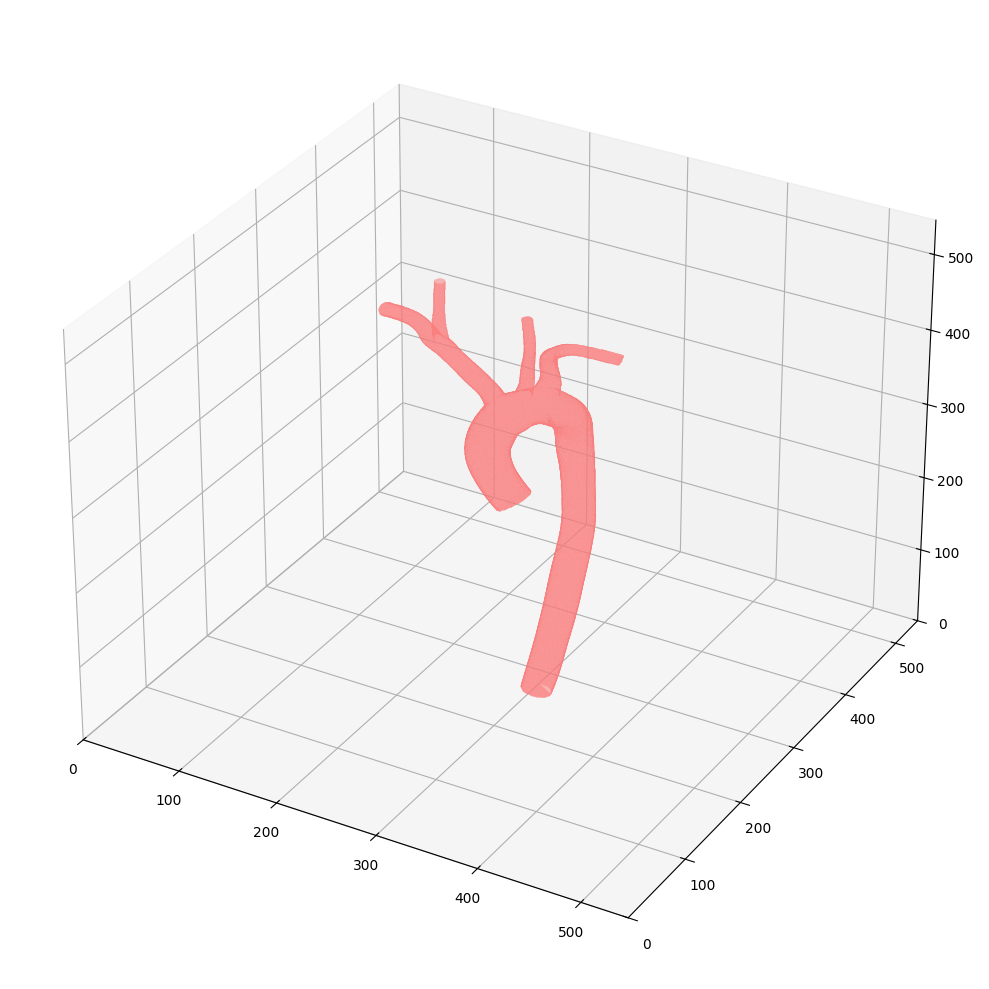

In [ ]:
visualize_3d([X[0]])

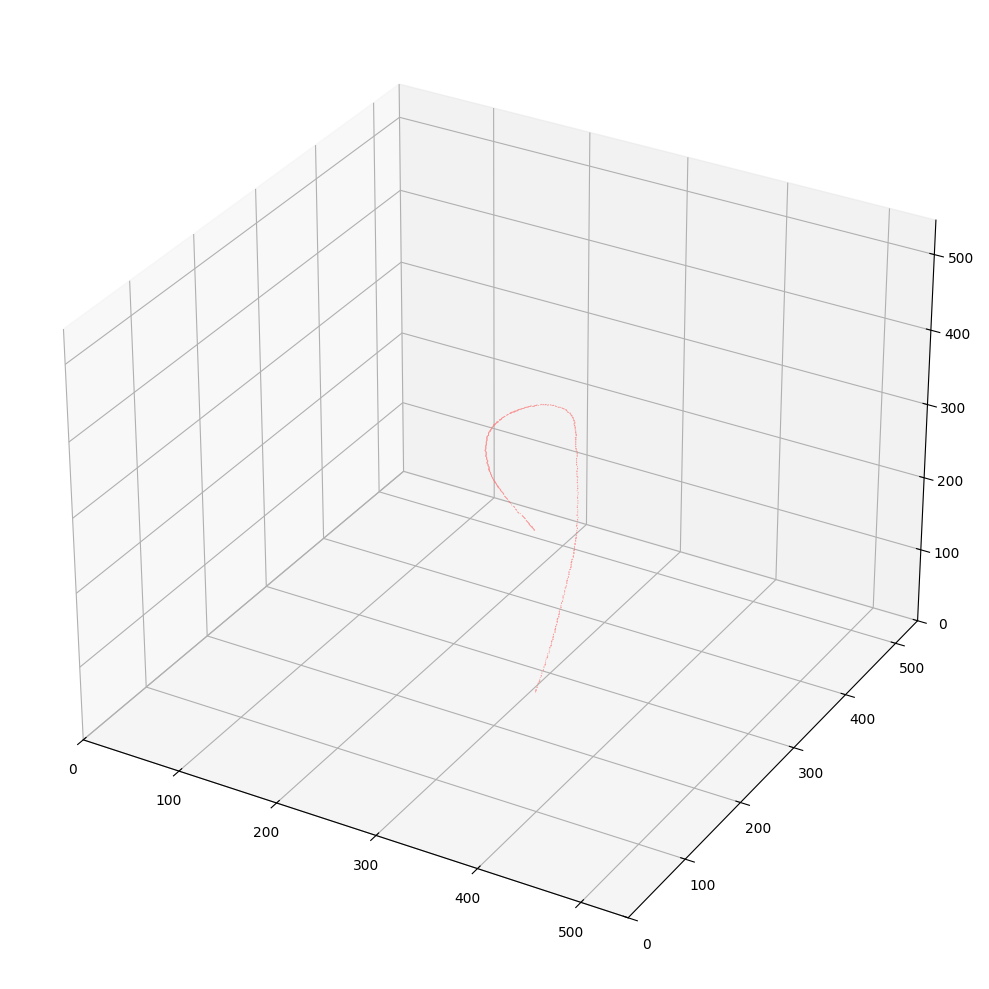

In [ ]:
visualize_3d([centerline_map[0]])

# Removal of branches based on automatically calculated radius

In [ ]:
from scipy import ndimage as ndi
from skimage.measure import label, regionprops
# label return labeled array, where all connected regions are assigned the same integer value

def remove_branches(aorta_binary, distance_percentile=75):
    # distance_percentile - percentile (0–100), below which the radius is considered too small

    distance = ndi.distance_transform_edt(aorta_binary)
    nonzero_distances = distance[aorta_binary > 0] #threshold
    if len(nonzero_distances) == 0:
        raise ValueError("The input mask is empty.")

    min_radius = np.percentile(nonzero_distances, distance_percentile)
    radius_voxels = int(np.ceil(min_radius))

    # Binary opening
    structure = np.ones((3, 3, 3))
    eroded = ndi.binary_erosion(aorta_binary, structure=structure, iterations=radius_voxels)
    cleaned = ndi.binary_dilation(eroded, structure=structure, iterations=radius_voxels)

    # Keep the largest component
    labeled = label(cleaned)
    regions = regionprops(labeled)
    if not regions:
        raise ValueError("No components found.")

    largest_region = max(regions, key=lambda x: x.area)
    aorta_main = (labeled == largest_region.label)
    return aorta_main.astype(np.uint8)

In [ ]:
aorta_cleaned = remove_branches(X[0], 75)

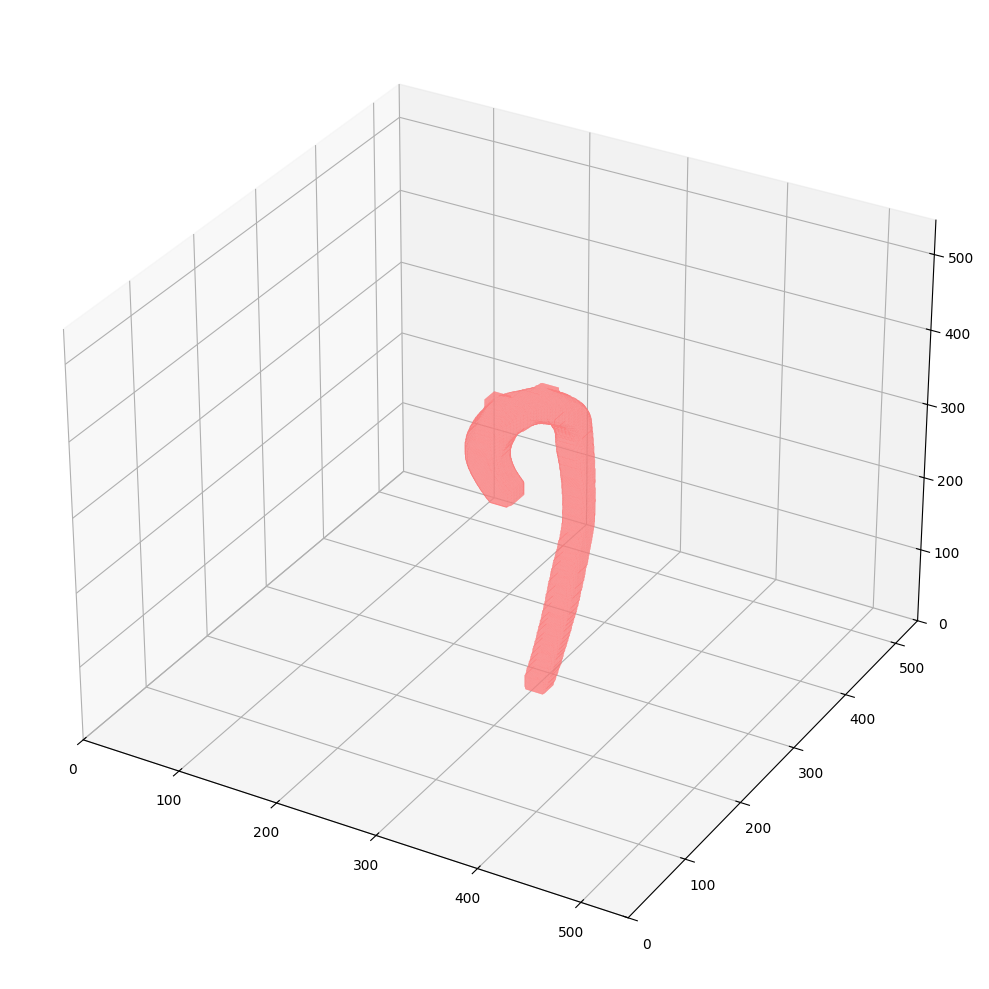

In [ ]:
visualize_3d([aorta_cleaned])

# Skeletonization

In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.2 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk

In [ ]:
def get_centerline3d(binary_aorta, num_points=20):
  aorta_inv = 1 - binary_aorta
  image_inv = sitk.GetImageFromArray(aorta_inv.astype(np.uint8))

  distance_map = sitk.SignedMaurerDistanceMap(image_inv, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
  distance_map_np = sitk.GetArrayFromImage(distance_map)

  centerline3d_list = []

  distance_map_copy = distance_map_np.copy()
  for _ in range(num_points):
    max_val = np.max(distance_map_copy)
    if max_val==0:
      break

    max_idx = np.argmax(distance_map_copy)
    z, y, x = np.unravel_index(max_idx, distance_map_copy.shape)
    centerline3d_list.append([z, y, x])

    radius = int(np.floor(max_val))
    z_min = max(0, z - radius)
    z_max = min(distance_map_copy.shape[0], z + radius)
    y_min = max(0, y - radius)
    y_max = min(distance_map_copy.shape[1], y + radius)
    x_min = max(0, x - radius)
    x_max = min(distance_map_copy.shape[2], x + radius)
    distance_map_copy[z_min:z_max, y_min:y_max, x_min:x_max] = 0

  return centerline3d_list

In [ ]:
centerline3d_list = get_centerline3d(aorta_cleaned)

In [ ]:
centerline3d_list

[[np.int64(276), np.int64(237), np.int64(393)],
 [np.int64(268), np.int64(226), np.int64(340)],
 [np.int64(300), np.int64(255), np.int64(410)],
 [np.int64(267), np.int64(231), np.int64(366)],
 [np.int64(319), np.int64(278), np.int64(409)],
 [np.int64(325), np.int64(297), np.int64(399)],
 [np.int64(311), np.int64(329), np.int64(355)],
 [np.int64(323), np.int64(316), np.int64(381)],
 [np.int64(304), np.int64(331), np.int64(337)],
 [np.int64(297), np.int64(332), np.int64(314)],
 [np.int64(293), np.int64(332), np.int64(293)],
 [np.int64(282), np.int64(327), np.int64(251)],
 [np.int64(286), np.int64(329), np.int64(265)],
 [np.int64(268), np.int64(316), np.int64(204)],
 [np.int64(254), np.int64(304), np.int64(163)],
 [np.int64(272), np.int64(320), np.int64(217)],
 [np.int64(278), np.int64(324), np.int64(234)],
 [np.int64(206), np.int64(269), np.int64(39)],
 [np.int64(215), np.int64(274), np.int64(60)],
 [np.int64(239), np.int64(292), np.int64(124)]]

# Interpolation

In [2]:
import numpy as np
from scipy.interpolate import splprep, splev

def interpolate(points, n, image_shape: tuple[int,int,int]):
  # n - number of points after interpolate

  def sort_by_proximity(points):
    points = np.array(points)
    unvisited = points[1:] # first point will be start
    path = [points[0]]

    while len(unvisited) > 0:
        last_point = path[-1]
        # euclidean distances from last point to all unvisited
        distances = np.linalg.norm(unvisited - last_point, axis=1)
        nearest_idx = np.argmin(distances)
        path.append(unvisited[nearest_idx])
        unvisited = np.delete(unvisited, nearest_idx, axis=0)

    return np.array(path)

  points = np.array(points)

  sorted_points_z = points[points[:, 2].argsort()]
  sorted_points = sort_by_proximity(sorted_points_z)
  sorted_points_T = sorted_points.T

  # interpolation
  tck, u = splprep(sorted_points_T, s=2.0)
  u_fine = np.linspace(0, 1, n)
  interp_points = splev(u_fine, tck)
  interp_centerline = np.stack(interp_points, axis=1)

  interp_voxel_indices = np.round(interp_centerline).astype(int)
  interp_voxel_indices = np.clip(interp_voxel_indices, [0, 0, 0], np.array(image_shape) - 1)

  centerline_mask = np.zeros(image_shape, dtype=np.uint8)
  for z, y, x in interp_voxel_indices:
      centerline_mask[z, y, x] = 1

  return centerline_mask

In [ ]:
centerline_mask = interpolate(centerline3d_list, 30, X[0].shape)

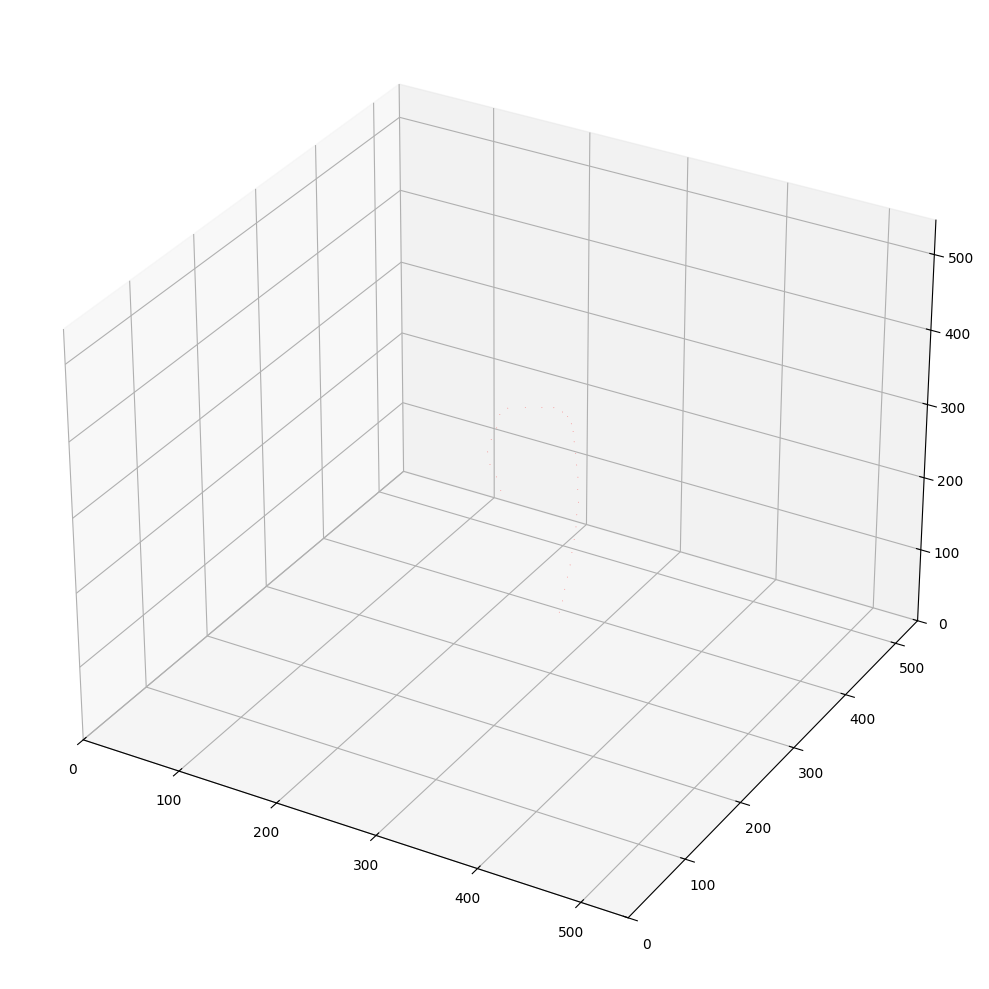

In [ ]:
visualize_3d([centerline_mask])

# Interpolation of the reference path

In [ ]:
gt = np.argwhere(centerline_map == 1)

In [ ]:
gt = interpolate(gt, 500, X[0].shape)

# Save .vtk

In [ ]:
header = X_headers[0]
print(header)

OrderedDict([('type', 'short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([231, 145, 462])), ('space directions', array([[-0.04480855,  0.        ,  0.        ],
       [ 0.        , -0.04480855,  0.        ],
       [ 0.        ,  0.        ,  0.04480855]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([ 4.84372122,  2.61684163, -2.57549126]))])


In [ ]:
file_name = names[0] + '.vtk'

In [ ]:
spacing = aorta_spacings[0]

In [ ]:
origin = space_origins[0]

In [ ]:
verts, faces, _, _ = measure.marching_cubes(centerline_mask, level=0.5)

verts = verts * spacing + origin

faces_flat = np.hstack([[3] + list(f) for f in faces])

mesh = pv.PolyData(verts, faces_flat)

mesh.save(file_name)

# Validation

In [ ]:
from scipy.spatial import cKDTree

def compare_binary_masks(reference, mask, spacing=(1.0, 1.0, 1.0), origin=(0.0, 0.0, 0.0), threshold=1.0):
    idx1 = np.argwhere(reference > 0)
    idx2 = np.argwhere(mask > 0)

    if len(idx1) == 0 or len(idx2) == 0:
        return {"dice": 0.0, "hd95": np.inf, "accuracy": 0.0}

    pts1 = idx1[:, ::-1] * spacing + origin
    pts2 = idx2[:, ::-1] * spacing + origin

    # Dice Score
    intersection = np.sum((reference > 0) & (mask > 0))
    volume1 = np.sum(reference > 0)
    volume2 = np.sum(mask > 0)
    dice = 2 * intersection / (volume1 + volume2)

    # Hausdorff 95%
    def hd95(a_pts, b_pts):
        tree_b = cKDTree(b_pts)
        dists_a_to_b, _ = tree_b.query(a_pts, k=1)
        tree_a = cKDTree(a_pts)
        dists_b_to_a, _ = tree_a.query(b_pts, k=1)
        hd_95 = np.percentile(np.concatenate([dists_a_to_b, dists_b_to_a]), 95)
        return hd_95

    hd = hd95(pts1, pts2)

    # Accuracy
    tree2 = cKDTree(pts2)
    distances, _ = tree2.query(pts1, k=1)
    acc = np.sum(distances <= threshold) / len(pts1)

    return {
        "dice": dice,
        "hd95": hd,
        "accuracy": acc * 100
    }

In [ ]:
results = compare_binary_masks(gt, centerline_mask, spacing=aorta_spacings[0], origin=space_origins[0], threshold=1.0)
results

{'dice': np.float64(0.05311542390194075),
 'hd95': np.float64(0.199210043290353),
 'accuracy': np.float64(96.3265306122449)}

In [ ]:
with open("results.txt", "a", encoding="utf-8") as file:
    file.write("\n")
    file.write(str(names[0]))
    file.write("\n")
    file.write(str(results))
    file.write("\n")